In [1]:
import logging
import math
import os

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import galsim

In [4]:
from chromatic_shear_sims import utils
from chromatic_shear_sims.stars import InterpolatedStarBuilder
from chromatic_shear_sims.throughputs import load_throughputs

In [5]:
throughputs = load_throughputs()

INFO:chromatic_shear_sims.throughputs:loading throughput for u-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_u.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for g-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_g.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for r-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_r.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for i-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_i.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for z-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_z.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for y-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_y.dat


In [10]:
star_builder = InterpolatedStarBuilder(
    "chromatic_weak_lensing.btsettl:BTSettl",
    band_1="g",
    band_2="i",
)

INFO:chromatic_shear_sims.stars:made inverse lookup table in 2.5223588943481445 seconds


In [11]:
BASE_FWHM = 0.7
BASE_WAVELENGTH = 700
ALPHA = -0.3
ZENITH_ANGLE = 45
PARALLACTIC_ANGLE = 0

base_psf = galsim.Gaussian(fwhm=BASE_FWHM)

psf = galsim.ChromaticAtmosphere(
    base_psf,
    BASE_WAVELENGTH,
    alpha=ALPHA,
    zenith_angle=ZENITH_ANGLE * galsim.degrees,
    parallactic_angle=PARALLACTIC_ANGLE * galsim.degrees,
)

In [12]:
psf_colors = [-0.5, 0.5, 1.5]
psf_stars = [
    star_builder(color)
    for color in psf_colors
]

observed_psfs = [
    galsim.Convolve([psf, psf_star])
    for psf_star in psf_stars
]

In [13]:
NX = 53
NY = 53
SCALE = 0.2
bands = ["g", "r", "i"]
observed_psf_images = {
    band: [
        observed_psf.drawImage(
            nx=NX,
            ny=NY,
            scale=SCALE,
            offset=-observed_psf.calculateCentroid(throughputs[band]) / SCALE,
            bandpass=throughputs[band],
        )
        for observed_psf in observed_psfs
    ]
    for band in bands
}

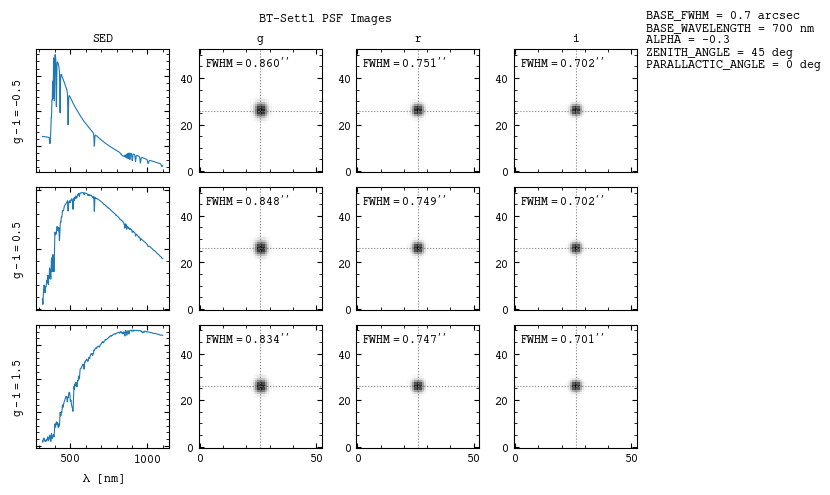

In [14]:
fig, axs = plt.subplots(
    len(psf_colors), len(bands) + 1,
    constrained_layout=True,
    sharex="col",
)
wl = np.linspace(
    throughputs["u"].blue_limit,
    throughputs["y"].red_limit,
    1000,
)

for i, psf_color in enumerate(psf_colors):
    spec = psf_stars[i].sed
    for j, band in enumerate(bands):
        psf_image = observed_psf_images[band][i]
        psf_sigma = psf_image.FindAdaptiveMom().moments_sigma * psf_image.scale
        psf_fwhm = 2 * math.sqrt(2 * math.log(2)) * psf_sigma
        
        axs[i, j + 1].imshow(psf_image.array, origin="lower")
        axs[i, j + 1].text(0.05, 0.95, f"$FWHM = {psf_fwhm:.3f}''$", transform=axs[i, j + 1].transAxes, ha="left", va="top")
        axs[i, j + 1].axvline((psf_image.ncol - 1) / 2, c="gray", ls=":")
        axs[i, j + 1].axhline((psf_image.ncol - 1) / 2, c="gray", ls=":")
        
    axs[i, 0].plot(wl, spec(wl))
    # axs[i, -1].set_ylabel("$f_{photons}$ [$photons/nm/cm^2/s$]")

for i, psf_color in enumerate(psf_colors):
    axs[i, 0].set_ylabel(f"$g - i = {psf_color}$")

for j, band in enumerate(bands):
    axs[0, j + 1].set_title(band)

axs[-1, 0].set_xlabel("$\lambda$ [$nm$]")
axs[0, 0].set_title("SED")

for ax in axs[:, 0]:
    ax.set_yticklabels([])

fig.suptitle(f"{star_builder.name} PSF Images")

fig.text(
    1, 1,
    (
        f"BASE_FWHM = {BASE_FWHM} arcsec\n"
        f"BASE_WAVELENGTH = {BASE_WAVELENGTH} nm\n"
        f"ALPHA = {ALPHA}\n"
        f"ZENITH_ANGLE = {ZENITH_ANGLE} deg\n"
        f"PARALLACTIC_ANGLE = {PARALLACTIC_ANGLE} deg"
    ),
    ha="left",
    va="top",
)

plt.show()